In [1]:
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# geospatial analysis
import folium
from folium import Marker
from folium.plugins import HeatMap

# nlp
from langdetect import detect
import spacy
from collections import Counter
from string import punctuation
import en_core_web_sm
import de_core_news_sm

In [2]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
sns.set_style("whitegrid")

In [3]:
jobs_path = './data/data_science_jobs_2020-10-01.json'
#cities_path = './data/postleitzahlen-deutschland/postleitzahlen-deutschland.shp'
#basemap_path = './data/xn--VG250_Bundeslndergrenzen-shp-inc/VG250_Bundesländergrenzen.shp'
coords_path = './data/DE.tab'

jobs_df = pd.read_json(jobs_path)
#cities_df = gpd.read_file(cities_path)
#basemap_df = gpd.read_file(basemap_path)
coords_df = pd.read_csv(coords_path, sep='\t', low_memory=False)

In [4]:
def remove_n(string):
    if type(string) == str:
        return string[1:]
    # return NoneType values without manipulation
    else:
        return string

jobs_df['company'] = jobs_df['company'].apply(remove_n)
jobs_df['salary'] = jobs_df['salary'].apply(remove_n)

#jobs_df.head(10)

In [26]:
# turn description list into string
def description_str(desc_list):
    return ''.join(desc_list)

jobs_df['description'] = jobs_df['description'].apply(description_str)

#jobs_df.loc[9]['description']

In [6]:
jobs_df.drop_duplicates(inplace=True)

In [7]:
year_hours = 2088
year_days = 261
year_months = 12

def get_start_values(salary_str):
    if salary_str == None:
        return np.nan
    else:
        start_str = salary_str.split(' € ')[0].replace('.', '')
        start_num = pd.to_numeric(start_str)
        if 'Stunde' in salary_str:
            return start_num * year_hours
        elif 'Tag' in salary_str:
            return start_num * year_days
        elif 'Monat' in salary_str:
            return start_num * year_months
        elif 'Jahr' in salary_str:
            return start_num
    
def get_end_values(salary_str):
    if salary_str == None:
        return np.nan
    elif not '-' in salary_str:
        return np.nan
    else:
        end_str = salary_str.split(' € ')[1].replace('- ', '').replace('.', '')
        end_num = pd.to_numeric(end_str)
        if 'Stunde' in salary_str:
            return end_num * year_hours
        elif 'Tag' in salary_str:
            return end_num * year_days
        elif 'Monat' in salary_str:
            return end_num * year_months
        elif 'Jahr' in salary_str:
            return end_num

# add two new columns: hourly_wage_from, hourly_wage_to
jobs_df['annual_income_from'] = jobs_df['salary'].apply(get_start_values)
jobs_df['annual_income_to'] = jobs_df['salary'].apply(get_end_values)

# round values to 2 decimals
jobs_df = jobs_df.round({'hourly_wage_from':2, 'hourly_wage_to':2})

# print first five rows with salary data
#jobs_df.dropna(subset=['salary']).head(5)

In [25]:
# drop unnecessary columns
coords_df = coords_df[['name', 'lat', 'lon']]

# drop rows with any NaN
coords_df.dropna(inplace=True)

# print cleaned data
#coords_df.info()

<a id='most_common_locations'></a>
### What are the most common locations in the dataset?

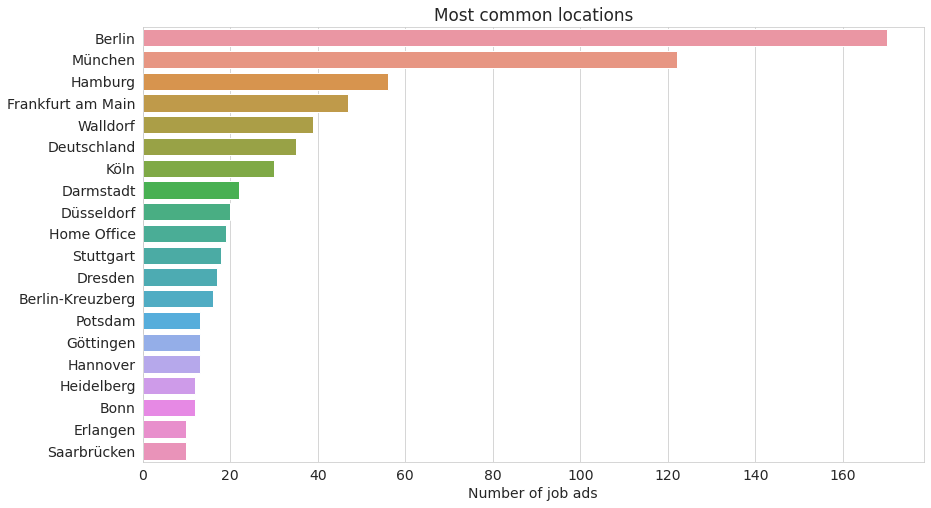

In [9]:
# 20 most common cities
most_common_locs = jobs_df['location'].value_counts()[:20]

plt.figure(figsize=(14,8))

plt.title('Most common locations')

most_common_locs_fig = sns.barplot(
    x=most_common_locs.values,
    y=most_common_locs.index.values
)

most_common_locs_fig.set_xlabel('Number of job ads')

plt.show()

<a id='heat_map'></a>
### Where are the most job locations?

In [27]:
# find lat for each location name
def get_lat(row):
    if row['location'].lower() in coords_df['name'].str.lower().values:
        # use first appearance of location name in case there is more than one
        return coords_df[coords_df['name'].str.lower() == row['location'].lower()]['lat'].iloc[0]        

# find lon for each location name
def get_lon(row):
    if row['location'].lower() in coords_df['name'].str.lower().values:
        # use first appearance of location name in case there is more than one
        return coords_df[coords_df['name'].str.lower() == row['location'].lower()]['lon'].iloc[0]
    
    
# add lat and lon columns to jobs_df
jobs_df['lat'] = jobs_df.apply(get_lat, axis=1)
jobs_df['lon'] = jobs_df.apply(get_lon, axis=1)

#jobs_df.head()

In [12]:
# dict for invalid city names except Berlin districts
invalid_cities_dict = {
    'Wolfsburg, Stadt' : 'Wolfsburg',
    'Marburg an der Lahn' : 'Marburg / Lahn',
    'Homburg': 'Homburg (Saar)',
    'Walldorf' : 'Walldorf (Baden)',
    'Nehren' : 'Nehren (Württemberg)',
    'Oberhaching' : 'Oberhaching bei München',
    'Rust' : 'Rust (Baden)',
    'Ilmenau' : 'Ilmenau, Thüringen',
    'Oberpfaffenhofen' : 'Oberpfaffenhofen, Oberbayern',
    'Neu Isenburg' : 'Neu-Isenburg'
}

def change_invalid_city_names(row):
    # don't change when coordinates already found
    if pd.notna(row['lon']):
        return row['location']
    # change Berlin district names to just 'Berlin'
    elif 'Berlin' in row['location']:
        return 'Berlin'
    # change city names that are in the dict above
    elif row['location'] in invalid_cities_dict.keys():
        return invalid_cities_dict[row['location']]
    # don't change in any other case (e.g. 'Homeoffice')
    else:
        return row['location']

jobs_df['location'] = jobs_df.apply(change_invalid_city_names, axis=1)

# add missing coordinates
def get_missing_lat(row):
    if pd.notna(row['lat']):
        return row['lat']
    else:
        return get_lat(row)
    
def get_missing_lon(row):
    if pd.notna(row['lon']):
        return row['lon']
    else:
        return get_lon(row)

jobs_df['lat'] = jobs_df.apply(get_missing_lat, axis=1)
jobs_df['lon'] = jobs_df.apply(get_missing_lon, axis=1)

In [13]:
base_map = folium.Map(location=[51.5,10], tiles='cartodbpositron', zoom_start=5.5)

heat_map_data = jobs_df[['title', 'location', 'lat', 'lon']].dropna()

# create noise matrix
noise = np.random.normal(0, 0.1, [len(heat_map_data), 2])

# add noise to heat_map_data
heat_map_data[['lat', 'lon']] = heat_map_data[['lat', 'lon']] + noise

# add heat map layer
HeatMap(
    data=heat_map_data[['lat', 'lon']],
    radius=20,
    blur=18,
    max_val=0.01
).add_to(base_map)


# job count for 20 locations with highest count
job_city_count = jobs_df.value_counts(['location', 'lat', 'lon']).sort_values(ascending=False)[:20]

# add marker layer with job counts
for loc, count in job_city_count.iteritems():
    Marker(
        location=[loc[1], loc[2]],
        #radius=1,
        tooltip=f"{loc[0]}: {count} jobs"
    ).add_to(base_map)

base_map

<a id='most_common_companies'></a>
### What are the most common companies in the dataset?

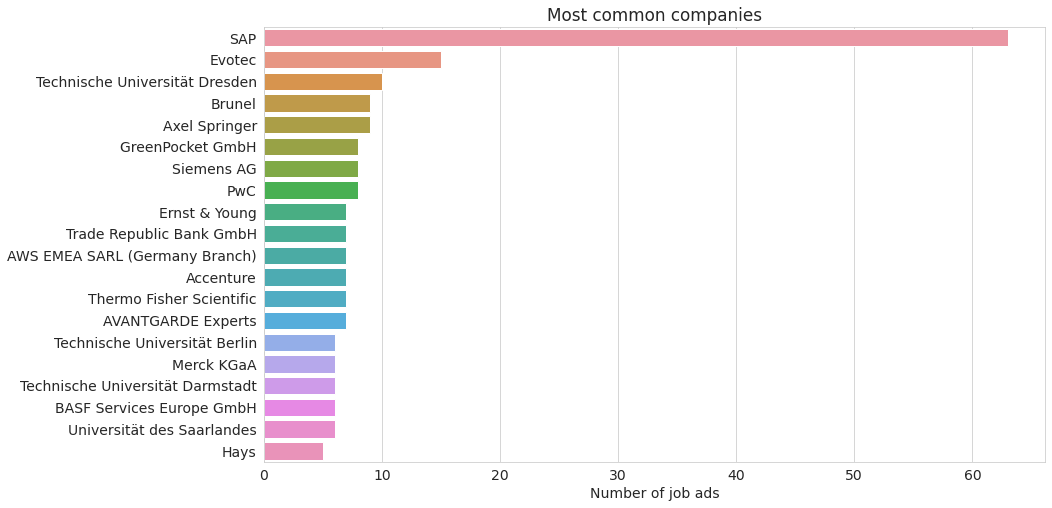

In [14]:
# 20 most common companies
most_common_companies = jobs_df['company'].value_counts()[:20]

plt.figure(figsize=(14,8))

plt.title('Most common companies')

most_common_companies_fig = sns.barplot(
    x=most_common_companies.values,
    y=most_common_companies.index.values
)

most_common_companies_fig.set_xlabel('Number of job ads')

plt.show()

<a id='salary_distribution'></a>
### How does the distribution of salaries look like?

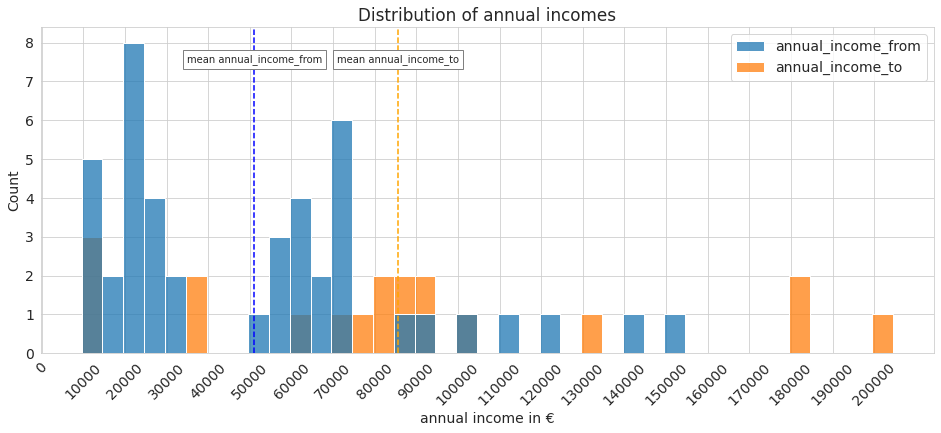

In [15]:
plt.figure(figsize=(16,6))

plt.title('Distribution of annual incomes')

wages_dist = sns.histplot(jobs_df[['annual_income_from', 'annual_income_to']], binwidth=5000)

ticks_x = [x for x in range(0,200001,10000)]

wages_dist.set_xticks(ticks_x)
wages_dist.set_xticklabels(ticks_x, rotation=45)

wages_dist.set_xlabel('annual income in €')

# vertical lines for mean values
plt.axvline(jobs_df['annual_income_from'].mean(), color='blue', linestyle='--', label='mean hourly_wages_from')
plt.axvline(jobs_df['annual_income_to'].mean(), color='orange', linestyle='--', label='mean hourly_wages_to',)

# annotate vertical lines
plt.text(jobs_df['annual_income_from'].mean(),7.5,'mean annual_income_from', ha='center', \
         fontsize=10, bbox=dict(facecolor='w', edgecolor='grey'))
plt.text(jobs_df['annual_income_to'].mean(),7.5,'mean annual_income_to', ha='center',  \
         fontsize=10, bbox=dict(facecolor='w', edgecolor='grey'))

plt.show()

<a id='highest_salaries'></a>
### Which companies list the highest salaries?

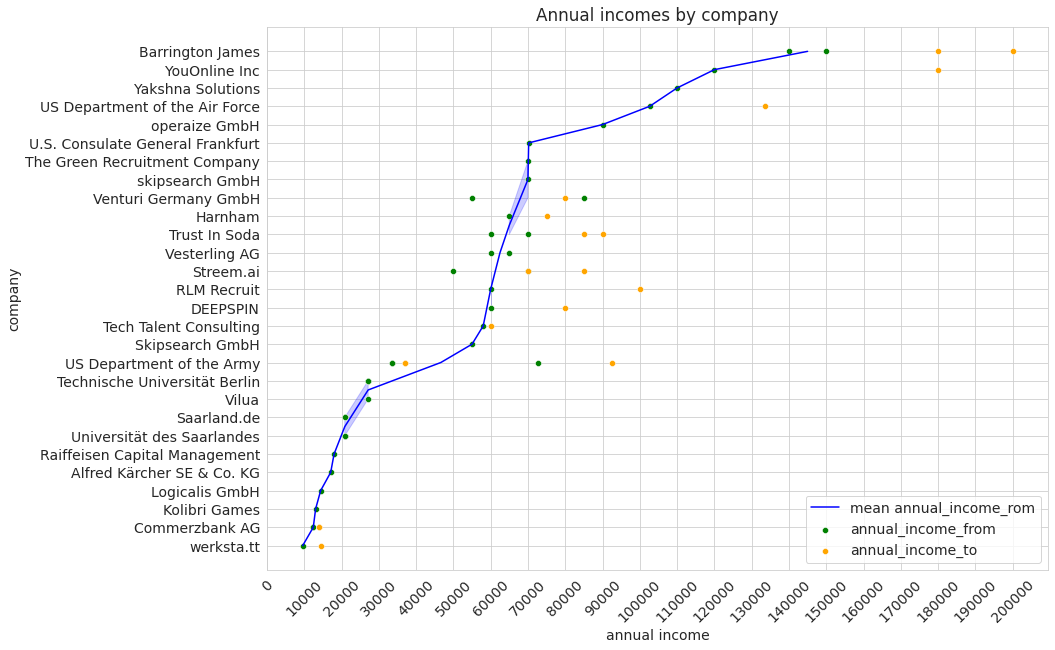

In [19]:
# subset containing only rows with salary not None, sorted by company
salaries = jobs_df.dropna(subset=['salary']).sort_values('company')

# mean values for hourly_wage_from and hourly_wage_to grouped by company
mean_per_comp = salaries.groupby('company').mean()
mean_per_comp = mean_per_comp.sort_values('annual_income_from', ascending=False)

plt.figure(figsize=(14,10))

plt.title('Annual incomes by company')

company_salary_from_mean = sns.lineplot(
    data=mean_per_comp,
    x='annual_income_from',
    y='company',
    color='b',
    label='mean annual_income_rom'
)

company_salary_from = sns.scatterplot(
    data=salaries,
    x='annual_income_from',
    y='company',
    color='g',
    label='annual_income_from'
)

company_salary_to = sns.scatterplot(
    data=salaries,
    x='annual_income_to',
    y='company',
    color='orange',
    label='annual_income_to'
)

ticks_x = [x for x in range(0,200001,10000)]

company_salary_from_mean.set_xticks(ticks_x)
company_salary_from_mean.set_xticklabels(ticks_x, rotation=45)

company_salary_from_mean.set_xlabel('annual income')

plt.legend(loc='lower right')

plt.show()

<a id='most_common_keywords'></a>
### What are the most common keywords in English descriptions?

In [21]:
nlp_en = en_core_web_sm.load()

In [22]:
# all English descriptions concatenated to one string
desc_texts_en = jobs_df[jobs_df['desc_lang'] == 'en']['description'].str.cat(sep=' ')

In [23]:
def get_keywords_en(text):
    keywords = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN']
    doc = nlp_en(text.lower())
    for token in doc:
        if(token.text in nlp_en.Defaults.stop_words or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            keywords.append(token.text)               
    return keywords